# SnapATAC Peak Matrix Analysis

Using data processed by Laksshman, pmat using peaks from day-wise bulk + cluster-wise bulk combined. ChromVAR analysis as well.

**NOTE**: As of 6 Feb, the pmat are attached to snap files only at `/srv/scratch`. Moreover, the pmat attached using SnapTools most likely counts fragments in peaks. For correctness, we should count Tn5 shifted 5' ends of reads in peaks.

In [3]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [276]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"
BARCODES_PREFIX = "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8"

file.list = c()
barcode.file.list = c()

for (d in DAYS) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}
DAYS
file.list
barcode.file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

[1] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D0.barcodes.txt" 
[2] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D2.barcodes.txt" 
[3] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D4.barcodes.txt" 
[4] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D6.barcodes.txt" 
[5] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D8.barcodes.txt" 
[6] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D10.barcodes.txt"
[7] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D12.barcodes.txt"
[8] "../20200122_snapATAC/barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D14.barcodes.txt"

In [277]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [278]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [279]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [ ]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [ ]:
x.sp

In [ ]:
dim(x.sp@pmat)

In [ ]:
rm(x.sp.list); # free memory
gc()

In [ ]:
x.sp = makeBinary(x.sp, mat="pmat");

In [ ]:
tempCov = Matrix::rowSums(x.sp@pmat)

In [ ]:
# remove UMIs with few bins
x.sp = x.sp[tempCov>1000, , mat="pmat"]
x.sp

In [ ]:
# sampling few cells for speed (simplified analysis)
# sample_idx = sort(sample(seq(1,dim(x.sp@bmat)[1]), 10000))
# x.sp = x.sp[sample_idx,]
# x.sp

In [ ]:
# OR keeping the same number of cells from each day
# fewest_per_day = min(table(x.sp@sample)) # TAKING HALVE
# print(fewest_per_day)

# idxs = c()
# for (d in DAYS) {
#     idxs = c(idxs, sample(which(x.sp@sample==d), fewest_per_day))
# }
# idxs = sort(idxs)

# table(x.sp@sample[idxs])

# x.sp = x.sp[idxs, ]

In [ ]:
x.sp

## Filtering bins

In [ ]:
black_list = read.table("../20200122_snapATAC/data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [ ]:
idy = queryHits(findOverlaps(x.sp@peak, black_list.gr));

In [ ]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [ ]:
# chr.exclude = seqlevels(x.sp@peak)[grep("random|chrM|chrUn", seqlevels(x.sp@peak))];
# idy = grep(paste(chr.exclude, collapse="|"), x.sp@peak);
# if(length(idy) > 0){x.sp = x.sp[,-idy, mat="pmat"]};

In [ ]:
x.sp

In [ ]:
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

## Dim Reduction

In [ ]:
rowCovs = Matrix::rowSums(x.sp@pmat)

In [ ]:
row.covs = log10(rowCovs+1);
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [ ]:
set.seed(1);
idx.landmark.ds = sort(sample(x = seq(nrow(x.sp)), size = 10000, prob = sampling_prob));
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [ ]:
table(x.landmark.sp@sample)

In [ ]:
# DOES NOT WORK OUT OF THE BOX SINCE bmat is hardcoded in trainRegression
# x.landmark.sp = runDiffusionMaps(
#     obj= x.landmark.sp,
#     input.mat="pmat", 
#     num.eigs=50
# );

In [ ]:
# modifying internal functions to make them work for pmat -- buggy now

myTrainRegression <- function(obj){
        row.covs = log(Matrix::rowSums(obj@pmat)+1,10); # EDITED THIS FROM bmat TO pmat
        row.covs.dens <- density(x = row.covs, bw = 'nrd', adjust = 1)
        sampling_prob <- 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps)
        idx.ds <- sort(sample(x = seq(row.covs), size = min(1000, length(row.covs)), prob = sampling_prob));
        jmat.tr = obj@jmat@jmat[idx.ds,idx.ds];
        b1.tr = obj@jmat@p1[idx.ds];
        b2.tr = obj@jmat@p2[idx.ds];
        # calculate the expected jaccard index matrix given the read depth
        emat.tr = SnapATAC:::.normOVE(b1.tr, b2.tr);
        # estimate the global scaling factor
        data = data.frame(x=emat.tr[upper.tri(emat.tr)], y=jmat.tr[upper.tri(jmat.tr)])	
        model <- lm(y ~ x + I(x^2), data);
        beta0 = as.numeric(model$coefficients)[1]
        beta1 = as.numeric(model$coefficients)[2]
        beta2 = as.numeric(model$coefficients)[3]
        obj@regModel = c(beta0, beta1, beta2);
        rm(jmat.tr);
        rm(emat.tr);
        rm(data);
        rm(model);
        rm(row.covs);
        return(obj)
}


myRunDiffusionMaps <- function(
        obj,
        input.mat=c("bmat", "pmat"), 
        num.eigs=20
){
    nmat.outlier = 0.999
    
    message("Epoch: computing jaccard similarity matrix ...");
    obj = SnapATAC:::runJaccard2(obj, obj, input.mat=input.mat);
    
    message("Epoch: fitting regression model ...");
    obj = myTrainRegression(obj);
    
    message("Epoch: performing normalization ...");
    obj = SnapATAC:::normJaccard(obj, obj@regModel[1], obj@regModel[2], obj@regModel[3]);
    
    # remove the outliers
    nmat.cutoff = quantile(obj@jmat@nmat, nmat.outlier);
    obj@jmat@nmat[obj@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: computing eigen decomposition ...");
    obj = SnapATAC:::runEigDecomp(obj, num.eigs);

    obj@smat@method = "DiffusionMaps";
    message("Epoch: Done");
    return(obj);
}

myRunDiffusionMapsExtension <- function(
        obj1,
        obj2,
        input.mat=c("bmat", "pmat")
){
    data.use.qry = obj2@pmat;
    peak.use.qry = obj2@peak;
        
    message("Epoch: computing jaccard similarity matrix ...");
    obj2 = SnapATAC:::runJaccard2(obj2, obj1, input.mat=input.mat);

    message("Epoch: performing normalization ...");
    obj2 = SnapATAC:::normJaccard(obj2, obj1@regModel[1], obj1@regModel[2], obj1@regModel[3])

    # remove the outliers
    nmat.cutoff = max(obj1@jmat@nmat);
    obj2@jmat@nmat[obj2@jmat@nmat > nmat.cutoff] = nmat.cutoff;
    
    message("Epoch: projecting query cells to the reference ...");
    obj2 = SnapATAC:::runEigDecompExd(obj1, obj2);
    
    message("Epoch: Done");
    obj2@pmat = data.use.qry
    obj2@peak = peak.use.qry
    
    return(obj2);
}

In [ ]:
x.landmark.sp = myRunDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="pmat", 
    num.eigs=50
);

In [ ]:
x.query.sp = myRunDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="pmat"
  );

In [ ]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT
rm(x.landmark.sp, x.query.sp); # free memory

# IMP: recompute since order has changed
rowCovs = Matrix::rowSums(x.sp@pmat)

In [ ]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [ ]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:12,
    k=15
  );

In [ ]:
library(leiden)

In [337]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   seed.use=11
);
x.sp@metaData$cluster = x.sp@cluster;

In [338]:
table(x.sp@cluster)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
7521 6728 6289 5419 5113 4455 4232 4228 3718 3533 3146 2982 2953 2771 2542 2325 
  17   18 
1812 1406 

In [ ]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:12, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

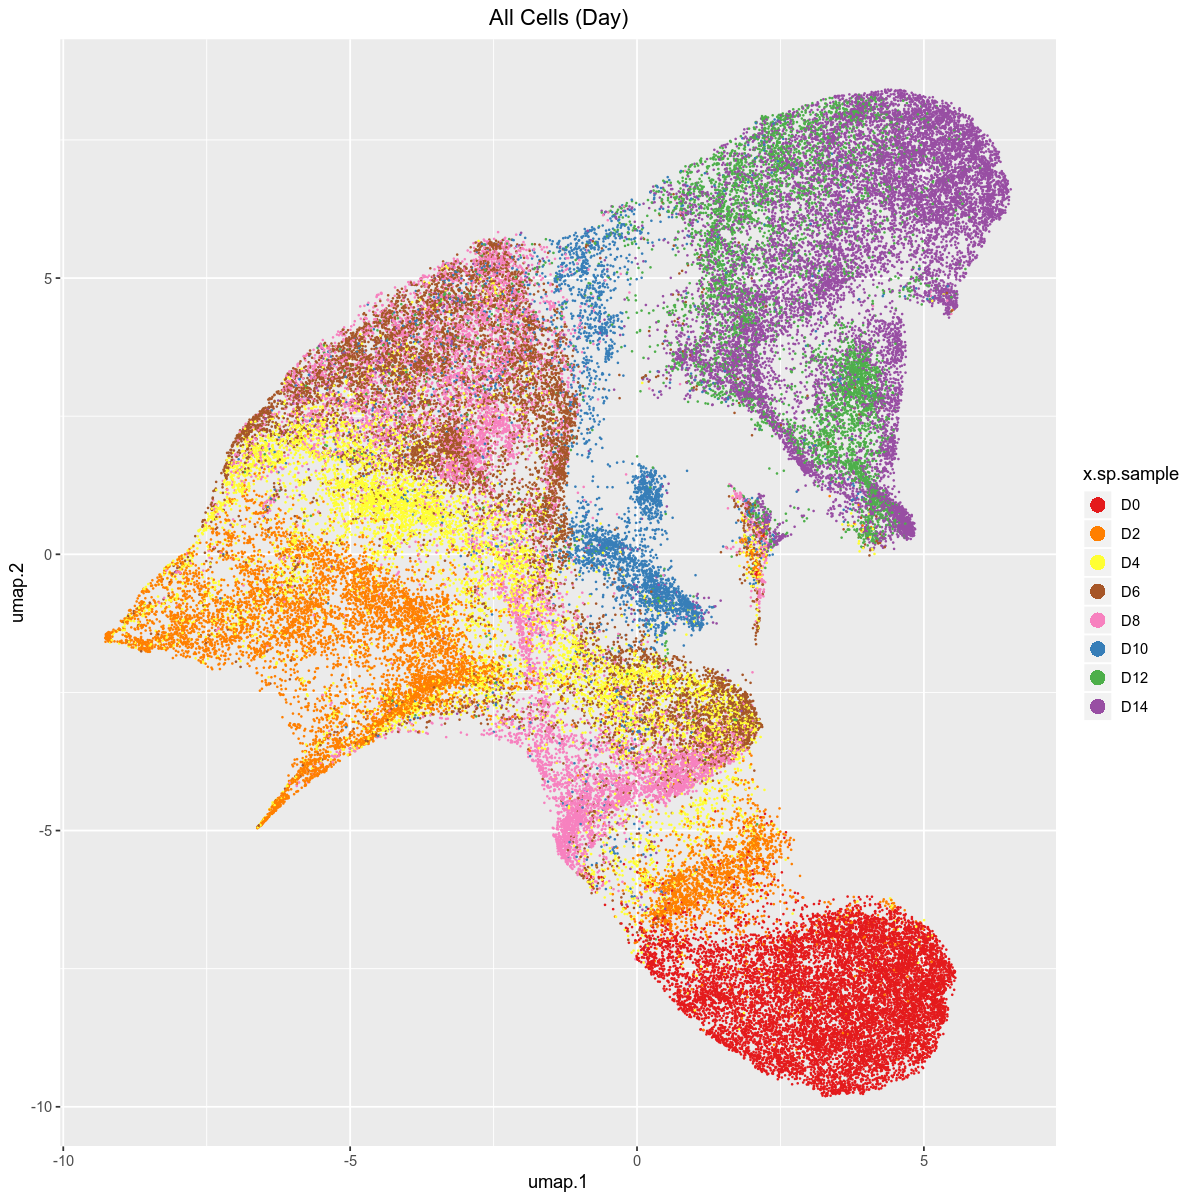

In [726]:
df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

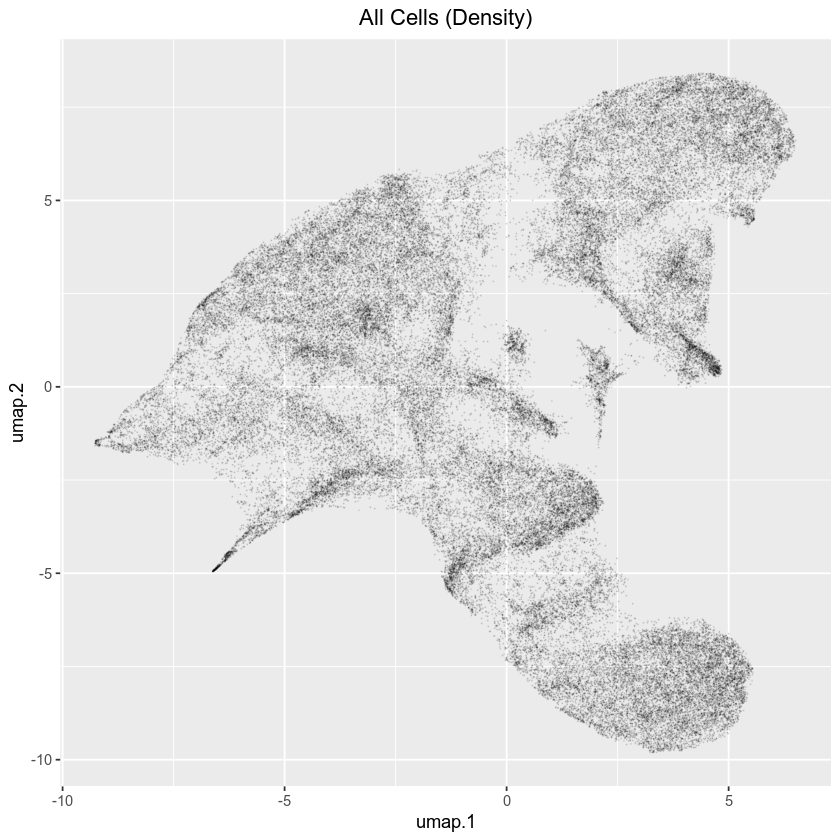

In [314]:
df = data.frame(x.sp@umap, x.sp@sample)

ggplot(df) +
geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
ggtitle("All Cells (Density)") + 
theme(plot.title = element_text(hjust = 0.5)) 

In [48]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [172]:
table(x.sp@sample[x.sp@cluster=="11"])


D10 D12 D14  D2  D4  D6  D8 
 10  23   7   1  60 668  81 

In [454]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@peak, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@pmat[,idy]) / Matrix::rowSums(x.sp@pmat);

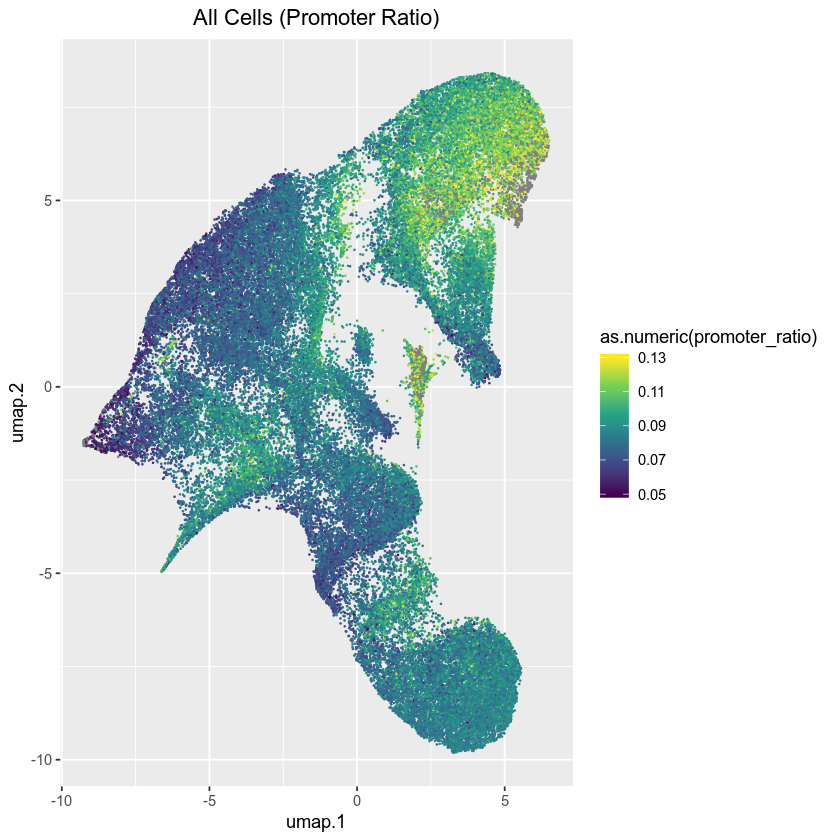

In [456]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(lim=c(0.05,0.13l)) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

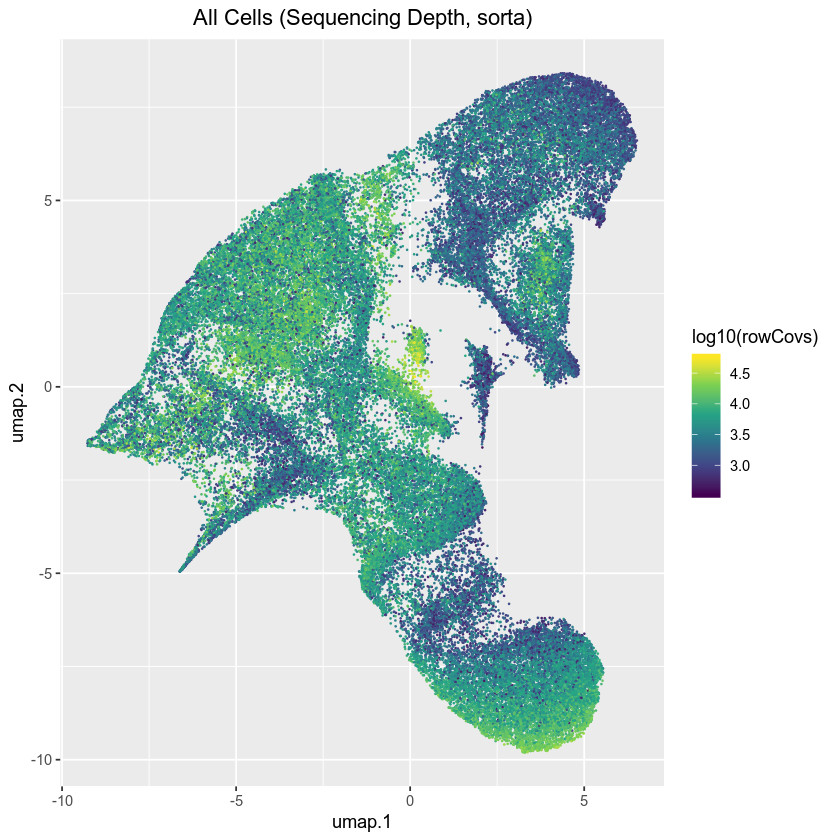

In [354]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

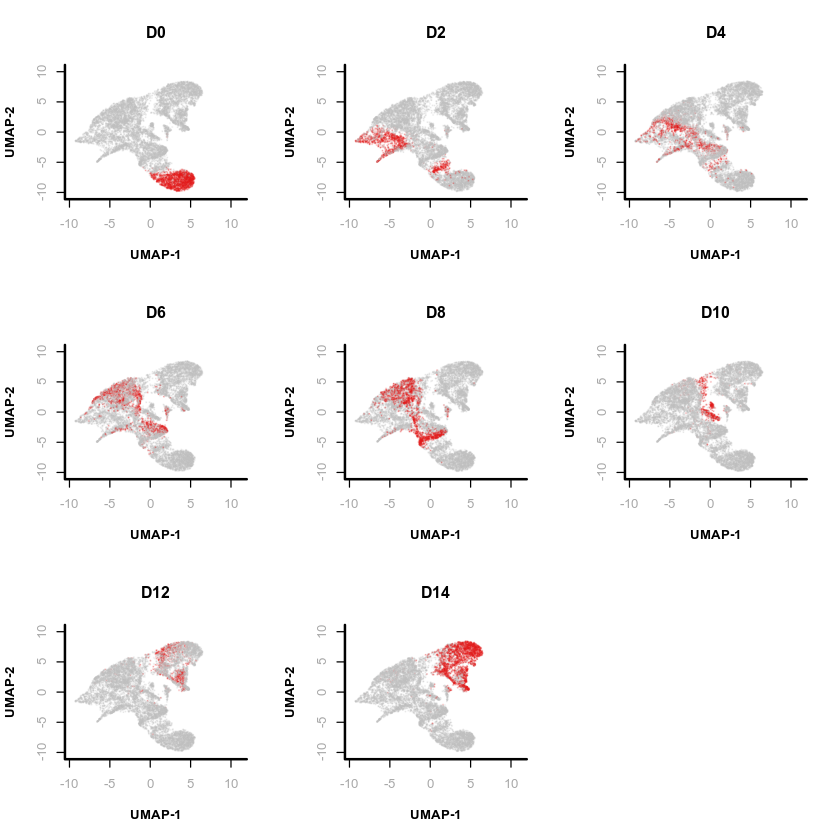

In [534]:
par(mfrow = c(3, 3));
for(d in DAYS){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

## ChromVar

In [492]:
library(chromVAR)
library(motifmatchr)
library(SummarizedExperiment);
library(BSgenome.Hsapiens.UCSC.hg38);
# library(JASPAR2016)
library(JASPAR2018)
library(TFBSTools)

In [938]:
opts <- list()
opts[["species"]] <- 9606
PFMatrixList <- getMatrixSet(JASPAR2018, opts)

In [ ]:
PFMatrixList[[length(PFMatrixList)+1]] = readJASPARMatrix("./data/jaspar/MA0143.4.jaspar")

In [958]:
PFMatrixList

PFMatrixList of length 453
names(453): MA0025.1 MA0030.1 MA0031.1 MA0051.1 ... MA1419.1 MA1420.1 MA1421.1 

In [831]:
# updating getJasparMotifs, which is called by runChromVAR,
# so that it uses Jaspar2018 motifs
getJasparMotifs <- function (collection, species) {
    return(PFMatrixList)
}

In [ ]:
x.sp@mmat = runChromVAR(
    obj=x.sp,
    input.mat="pmat",
    genome=BSgenome.Hsapiens.UCSC.hg38,
    min.count=10,
    species="Homo sapiens"
  );

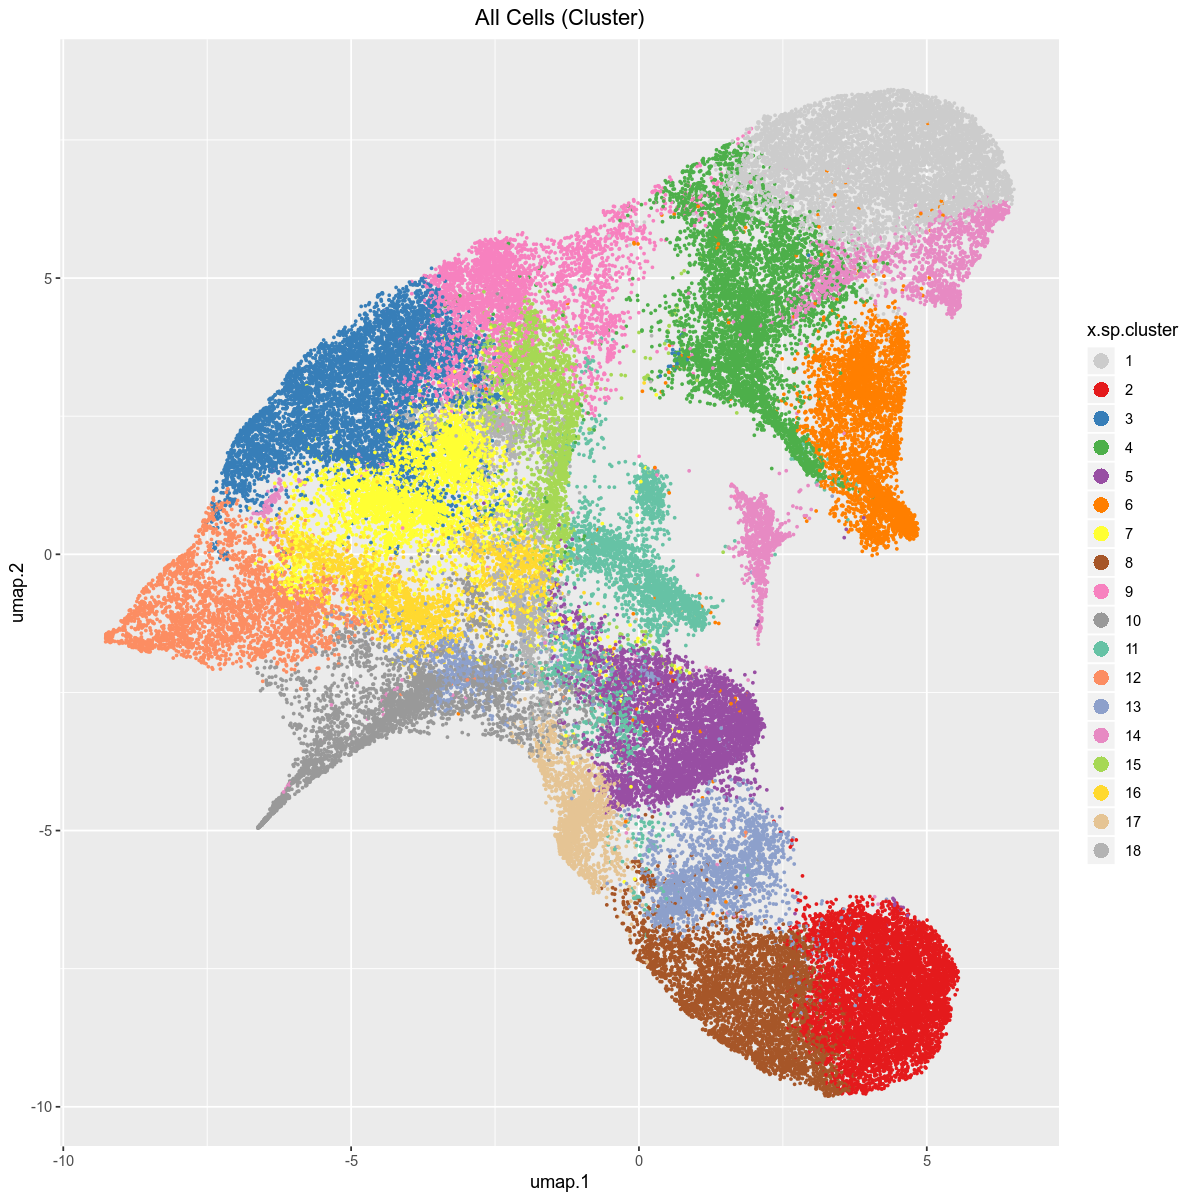

In [658]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(size=0.4, alpha=1) +
scale_colour_manual(values = col_vector[seq(45,74,1)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [891]:
table(x.sp@sample[x.sp@cluster=="4"])


 D10  D12  D14   D4   D6   D8 
  71 1776 3505    1   54   12 

In [576]:
table(x.sp@cluster[x.sp@sample=="D2"])


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   0  100   69    0   83    8  150  179    0 2032   31 2370 2126  109    1 1485 
  17   18 
   8    6 

In [959]:
df = data.frame(x.sp@umap, x.sp@cluster, x.sp@sample, x.sp@mmat)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]
colnames(df) = c(colnames(df)[1:4], sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [960]:
colnames(df)[grep("SOX", colnames(df))]

[1] "SOX9"  "SOX21" "SOX4"  "SOX8"  "SOX10" "SOX13" "SOX15" "SOX2"

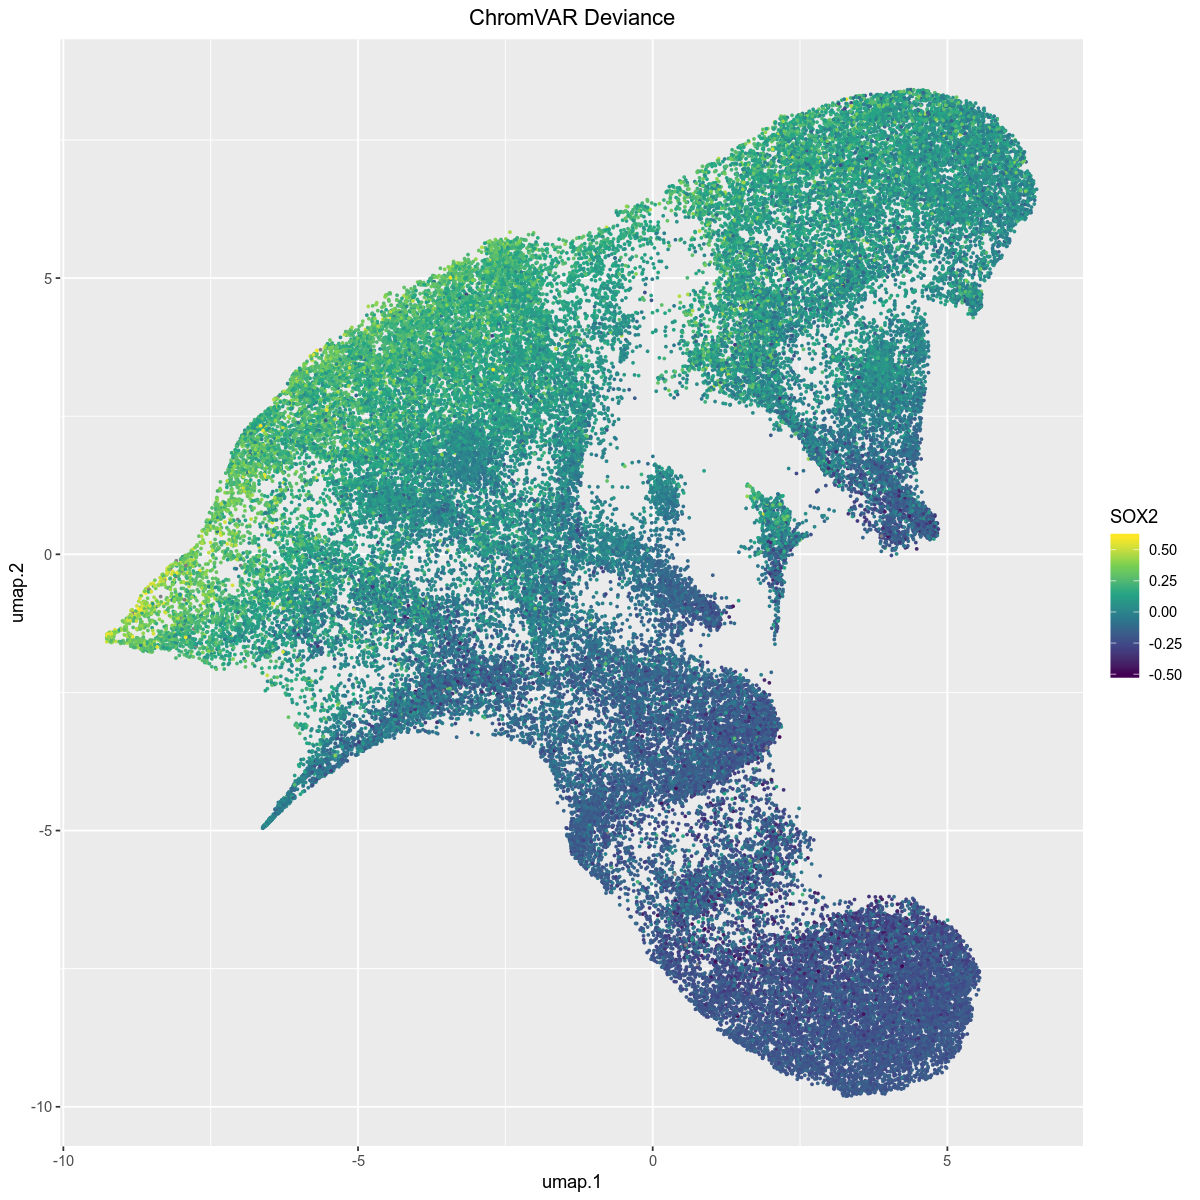

In [973]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(df,
# ggplot(df[(df$x.sp.sample=="D2"),], 
       aes(x=umap.1, y=umap.2, col=SOX2)) +
geom_point(size=0.4, alpha=1) +
scale_color_viridis_c(limit=c(-0.5,0.6)) +
ggtitle("ChromVAR Deviance") + 
theme(plot.title = element_text(hjust = 0.5)) 

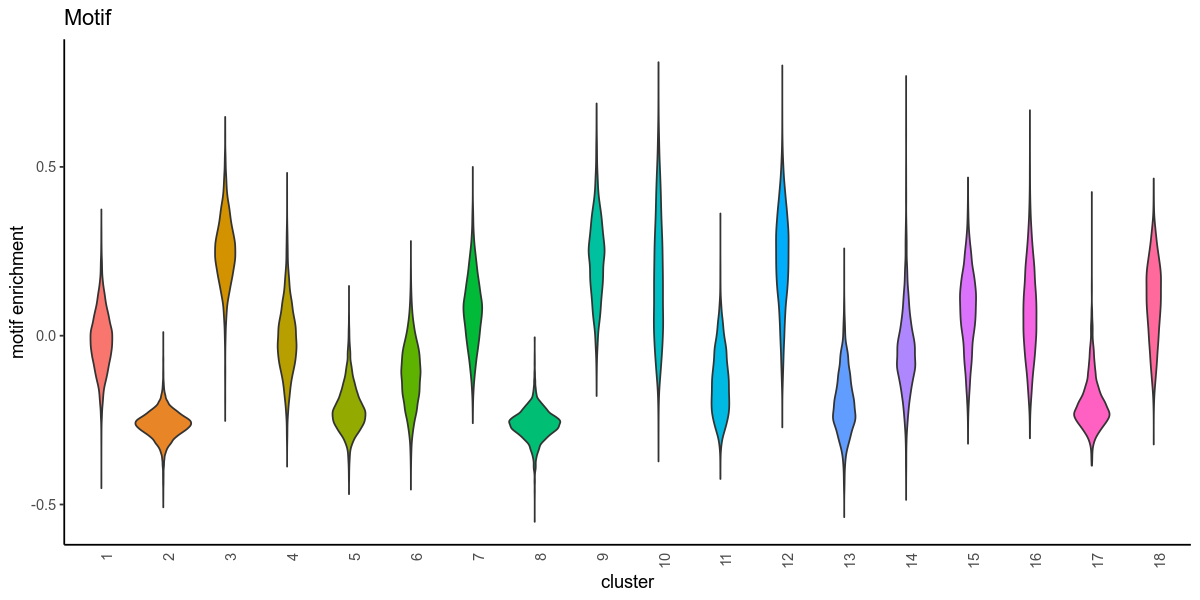

In [972]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(df, aes(x=x.sp.cluster, y= KLF4, fill=x.sp.cluster)) + 
    theme_classic() +
    geom_violin() + 
    xlab("cluster") +
    ylab("motif enrichment") + 
    ggtitle("Motif") +
    theme(
#           plot.margin = margin(5,1,5,1, "cm"),
          axis.text.x = element_text(angle = 90, hjust = 1),
          axis.ticks.x=element_blank(),
          legend.position = "none"
);

In [471]:
max(by_cluster[,c("MA0668.1_NEUROD2")])-min(by_cluster[,c("MA0668.1_NEUROD2")])

[1] -0.09358048410 -0.08227930004 -0.07293193552 -0.05033790083 -0.03061087983
 [6] -0.02477623461 -0.01355072309 -0.01047063761 -0.00331939726  0.00007782852
[11]  0.00294719337  0.00748435232  0.01449978995  0.01866087396  0.03568313005
[16]  0.06460323027  0.06640631390  0.09666884675

In [690]:
by_cluster = aggregate(x.sp@mmat,  list(x.sp@cluster), mean)

In [692]:
max_for_cluster = by_cluster[,apply(by_cluster, 2, which.max)=="12"]
length(max_for_cluster)

[1] 60

In [694]:
lapply(strsplit(colnames(max_for_cluster)[rev(order(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))], "_"), "[[", 2)[1:10]

[[1]]
[1] "PHOX2A"

[[2]]
[1] "PROP1"

[[3]]
[1] "CDX1"

[[4]]
[1] "DBP"

[[5]]
[1] "TEF"

[[6]]
[1] "TBX20"

[[7]]
[1] "ZNF410"

[[8]]
[1] "HOXA13"

[[9]]
[1] "TBX19"

[[10]]
[1] "TBX21"

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, min)))

In [ ]:
rev(sort(apply(max_for_cluster, 2, max)-apply(max_for_cluster, 2, function (x) {rev(sort(x))[2]})))

## Write ChromVAR outputs

In [998]:
df = data.frame(x.sp@barcode, x.sp@sample, x.sp@cluster, x.sp@umap, x.sp@mmat)
colnames(df) = c("barcode", "sample", "cluster", "umap1", "umap2", sub("::", "-", lapply(PFMatrixList, function(x) {return (x@name)})))

In [1000]:
head(df)

barcode          sample cluster umap1    umap2     NFIL3       FOXF2      
X   AAACACGCTCCTCAAA D0     2       4.772466 -6.667715 -0.29156522  0.04831392
X.1 AAACACGCTGATCCAT D0     8       2.130361 -9.291731 -0.14924478 -0.02713026
X.2 AAACACGCTTAACGAA D0     2       3.970016 -6.364377 -0.17441898  0.70271959
X.3 AAACCGTACCTTTAGG D0     8       1.864989 -9.122412 -0.06647693  0.02056991
X.4 AAACGAAACCTGGAAG D0     2       4.316830 -8.065972 -0.02258107  0.18237165
X.5 AAACGACCTCGTTATG D0     2       3.097259 -7.880262 -0.36605815 -0.09814538
    FOXD1       IRF2        MZF1        ⋯ RORC        SOX15       TFE3       
X    0.28102296  0.22136798 -0.03881762 ⋯  0.08225243 -0.16913721  0.07303538
X.1 -0.08005059 -0.01544193 -0.04508601 ⋯ -0.09360895 -0.13180443  0.07800702
X.2  0.17100717 -0.14903450 -0.02240269 ⋯  0.17923103  0.06359224 -0.32904082
X.3 -0.02776249 -0.07696805 -0.04315734 ⋯ -0.03131016 -0.17688009 -0.02165383
X.4  0.09519949 -0.09202283 -0.03123361 ⋯ -0.06294978 -0.12409792  0.09560575
X.5 -0.11535767 -0.00924187 -0.08518098 ⋯ -0.27012123 -0.22186109 -0.18973382
    VDR         EGR1        IRF3        IRF4        IRF5         TCF7L1     
X   -0.10883029 -0.21835569 -0.03517205  0.26295210  0.248802477 -0.11725196
X.1 -0.07400591 -0.02444856 -0.02412590  0.08252827 -0.012135779 -0.06834647
X.2 -0.06832553 -0.18014452 -0.08573979 -0.02277189  0.021652037 -0.15995649
X.3  0.02693999 -0.01674927 -0.02504446  0.04404067 -0.039067945 -0.10577402
X.4  0.02904725 -0.02827945 -0.07387822  0.12288002  0.073044264 -0.15729929
X.5  0.16969344 -0.04544223 -0.12885476  0.34747333  0.007006643 -0.20648510
    SOX2      
X   -0.2296258
X.1 -0.2070722
X.2 -0.1395883
X.3 -0.1931231
X.4 -0.1599006
X.5 -0.1273571

In [1001]:
gz = gzfile("./out/chromvar.tsv.gz", "w")
write.table(df, gz, sep='\t', row.names = F, quote = F)
close(gz)

## Write Fragment for each cluster (UNTESTED FOR pmat)

In [290]:
writeClusterFragmentsToBed <- function(
    obj, 
    output.prefix,
    path.to.snaptools,
    buffer.size=500,
    num.cores=10
){
    fileList = as.list(unique(obj@file));
 
    # check if files are all snap files
    if(any(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)
        print("error: these files are not snap file")
        print(fileList[idx])
        stop()
    }
    
    # check if FM session exist
    if(any(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)
        print("error: the following nsap files do not contain FM session")
        print(fileList[idx])
        stop()
    }
        
    # write the following barcodes down
    barcode.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".barcode.txt");
    })

    bed.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".bed.gz");
    })
    
    # write down the barcodes
    cat("Epoch: extracting fragments from each snap files ...\n", file = stderr())
    flag.list = lapply(seq(fileList), function(i){
        file.name = fileList[[i]];
        idx = which(obj@file == file.name);
        barcode.use = obj@barcode[idx]
        message(barcode.files[[i]])
        message(bed.files[[i]])
        message(fileList[[i]])
        write.table(barcode.use, file = barcode.files[[i]], append = FALSE, quote = FALSE, sep = "\t",
                         eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                         col.names = FALSE, qmethod = c("escape", "double"),
                         fileEncoding = "")
        
    })

    # extract the fragments belong to the barcodes    
    flag.list = mclapply(seq(fileList), function(i){
        flag = system2(command=path.to.snaptools, 
            args=c("dump-fragment", 
                   "--snap-file", fileList[[i]], 
                   "--output-file", bed.files[[i]], 
                   "--barcode-file", barcode.files[[i]],
                   "--buffer-size", buffer.size
                   )        
            )                
    }, mc.cores=num.cores);
    
    # combine these bed files
    combined.bed = paste(output.prefix, ".bed.gz");
    flag = system2(command="cat", 
        args=c(paste(bed.files, collapse = ' '),
               ">", combined.bed
               )        
        )                
}

In [ ]:
cluster_names = names(table(x.sp@cluster))
# mclapply(seq(cluster_names), function(i){
#     print(cluster_names[i]);
#     writeClusterFragmentsToBed(
#         obj=x.sp[which(x.sp@cluster==cluster_names[i]),], 
#         output.prefix=paste0("./snapATAC_sessions/20200125_n76770/cluster_beds/idx", cluster_names[i]),
#         path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
#         buffer.size=500, 
#         num.cores=1
#    );
#  }, mc.cores=5);

## Export Meta Data for Session (UNTESTED FOR pmat)

In [263]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./snapATAC_sessions/20200125_n76770/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))

In [53]:
write.table(x.sp@smat@dmat, "./snapATAC_sessions/20200125_n76770/eig_mat.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [74]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp@feature),
                       starts=start(x.sp@feature)-1,
                       ends=end(x.sp@feature)),
            file="./snapATAC_sessions/20200125_n76770/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [16]:
writeMM(x.sp@bmat, file="./snapATAC_sessions/20200125_n76770/5kb.sparse.mm")

NULL

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL